# Project : inverse kinematics and resolved rate control

In this project, we will implement an inverse kinematics algorithm and controllers for the Kuka iiwa 14 robot using the results from Project 1.

## Instructions
* Answer all questions in the notebook
* You will need to submit on Brightspace: 
    1. the code you wrote to answer the questions in a Jupyter Notebook. The code should be runnable as is.
    2. a 2-3 pages report in pdf format (pdf only) detailing the methodology you followed to answer the questions as well as answers to the questions that require a typeset answer. You may add the plots in the report (does not count for the page limit) or in the Jupyter notebook.

As a reminder, the [Kuka iiwa 14 robot](https://www.kuka.com/en-us/products/robotics-systems/industrial-robots/lbr-iiwa) has 7 revolute joints and its kinematics is described in the picture below:

![](./kuka_kinematics.png "Kuka iiwa 14 Kinematic Model")

# Starting the visualization environment

The following code will start a visualization environment (click on the printed address to see the robot)

You need to run this only ONCE. Each time you run this cell you will get a new display environment (so you need to close the previous one!)

This should work out of the box on Google Colab and you local Jupyter Notebook (make sure you have installed the right libraries in your local computer if you do not use Colab).

In [1]:
# start visualization environment
import numpy as np
import robot_visualizer
import time
import math
from scipy.linalg import expm


import matplotlib.pyplot as plt

robot_visualizer.start_robot_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
You should see the Kuka iiwa robot now when going to this page: http://127.0.0.1:7005/static/


# Displaying an arbitrary configuration

As in the previous project, you can use the following function to display arbitrary configurations of the robot

In [2]:
# here we display an arbitrary configuration of the robot
q = np.random.sample([7])
print(f'we show the configuration for the angles {q}')
robot_visualizer.display_robot(q)

we show the configuration for the angles [0.28363757 0.46751525 0.18720838 0.26309762 0.0762171  0.12213131
 0.24848027]


## Question 1: inverse kinematics
* Write a function ``compute_IK_position`` that gets a desired end-effector 3D position (in spatial frame) and returns a vector of joint angles that solves the inverse kinematics problem
* The file ``desired_end_effector_positions.npy`` contains a sequence of 10 desired end-effector positions. For all the positions attainable by the robot, compute an inverse kinematics solution. For the positions for which an inverse kinematics solution does not exist, what is the issue and how close can you get the end-effector to the desired position?
* Write a function ``compute_IK_position_nullspace`` that solves the inverse kinematics problem and additionally uses joint redundancy (i.e. the nullspace) to try and keep the joints close to the following configuration $[1,1,-1,-1,1,1,1]$. Explain how you used the nullspace to implement this function.
* Use this new function to reach the positions set in the file ``desired_end_effector_positions.npy``, how do the solutions compare to the first ones you found?

In [3]:
# build essential functions
def vec_to_skew(w):
    skew = np.array([[0,-w[2,0],w[1,0]],[w[2,0],0,-w[0,0]],[-w[1,0],w[0,0],0]])
    return skew

def twist_to_skew(V):
    w = V[0:3]
    v = V[3:]
    skew = np.hstack((vec_to_skew(w),v))
    skew = np.vstack((skew,np.zeros(4)))
    return skew

def exp_twist_bracket(V):
    w = V[:3]
    v = V[3:]
    theta = np.linalg.norm(w)
    w_vector = w/theta
    I = np.identity(3)
    R = I  + vec_to_skew(w_vector)*math.sin(theta) + vec_to_skew(w_vector).dot(vec_to_skew(w_vector))*(1-math.cos(theta)) 
    p = (I + vec_to_skew(w_vector)*((1-math.cos(theta))/theta) + vec_to_skew(w_vector).dot(vec_to_skew(w_vector))*(1 - math.sin(theta)/theta)).dot(v)
    T_pre = np.hstack((R,p))
    row_end = np.array([0,0,0,1])
    T = np.vstack((T_pre,row_end))
    return T

def inverseT(T):
    R = T[:3,:3]
    p = T[:3,3].reshape(3,1)
    inverseT_pre = np.hstack((R.T,-R.T.dot(p)))
    row_end = np.array([0,0,0,1])
    inverseT = np.vstack((inverseT_pre,row_end))
    return inverseT

def getAdjoint(T):
    R = np.array(T[:3,:3])
    p = np.array([T[:3,3]]).T
    p_skewR = vec_to_skew(p).dot(R)
    row_1 = np.hstack((R,np.zeros((3,3))))
    row_2 = np.hstack((p_skewR,R))
    AdjointT = np.vstack((row_1,row_2))
    return AdjointT

def get_space_jacobian(theta):
    S = np.array([[0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, -1, 0, 1, 0],
                [1, 0, 1, 0, 1, 0, 1],
                [0, -0.36, 0, 0.78, 0, -1.18, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0]])
    J_S = np.array([[]]*6)
    M = np.identity(4)
    for i in range(theta.shape[0]):
        J_S = np.hstack((J_S,getAdjoint(M).dot(S[:,i].reshape(6,1))))
        M = M.dot(expm(twist_to_skew(S[:,i].reshape(6,1))*theta[i,0]))
    return J_S

def forward_kinematics(theta):
    M = np.array([[1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 1.301],
                [0, 0, 0, 1]])
    S = np.array([[0, 0, 0, 0, 0, 0, 0],
                [0, 1, 0, -1, 0, 1, 0],
                [1, 0, 1, 0, 1, 0, 1],
                [0, -0.36, 0, 0.78, 0, -1.18, 0],
                [0, 0, 0, 0, 0, 0, 0],
                [0, 0, 0, 0, 0, 0, 0]])
    
    for i in reversed(range(theta.shape[0])):
        M = expm(twist_to_skew(S[:,i].reshape(6,1))*theta[i,0]).dot(M)
    return M

In [4]:
# Question 1: inverse kinematics
# load the file
with open('desired_end_effector_positions.npy', 'rb') as f:
    desired_endeff = np.load(f)
    
# first we display the robot in 0 position
robot_visualizer.display_robot(np.zeros([7,1]))
    
# for each end-eff position
for i in range(desired_endeff.shape[1]):
    # displays the desired endeff position
    robot_visualizer.display_ball(desired_endeff[:,i])
    time.sleep(1.) 

In [5]:
# write a function compute_IK_position
def compute_IK_position(p_des,theta0):
    threhold = 0.001 # end-effector position error
    alpha = 0.1 # interation parameter
    epsilon = 10e-4
    maxiteration = 100 # max iteration times
    theta = theta0
    p_des = p_des.reshape(3,1)
    
    for i in range(maxiteration):
        p = forward_kinematics(theta)[0:3,3]
        p = p.reshape(3,1)
        Trans = np.vstack((np.hstack((np.identity(3),-p)),np.array([0,0,0,1])))
        J = np.dot(getAdjoint(Trans),get_space_jacobian(theta))[3:6,:]  # jacobian in the frame at endeffector origin/orientation as space frame
        J_pinv = J.T.dot(np.linalg.inv(J.dot(J.T) + epsilon*np.eye(3)))  # presudo jacobian
        
        err = p_des - p
        err = err.reshape(3,1)
        
        dtheta = J_pinv.dot(err)        
        theta = theta + alpha*dtheta
        
        if i == maxiteration - 1:
            print(f'not exist, smallest error is {np.linalg.norm(err)}')
        if np.linalg.norm(err) < threhold:
            print('exist')
            break 
        
    return theta

# compute inverse kinematics solution for all positions and visualization
for i in range(desired_endeff.shape[1]):
    print(f'position {i} :')
    p_des = desired_endeff[:,i]
    theta0 = np.array([[0],[0],[0],[0],[0],[0],[0]])
    robot_visualizer.display_ball(desired_endeff[:,i])
    robot_visualizer.display_robot(compute_IK_position(p_des,theta0))
    time.sleep(1.) 

position 0 :
not exist, smallest error is 0.28302493534091155
position 1 :
exist
position 2 :
exist
position 3 :
exist
position 4 :
exist
position 5 :
not exist, smallest error is 0.06579915320419537
position 6 :
not exist, smallest error is 0.3856420016496059
position 7 :
not exist, smallest error is 0.041431930268121954
position 8 :
exist
position 9 :
exist


In [7]:
# compute_IK_position_nullspace
def compute_IK_position_nullspace(p_des,theta0):
    threhold = 0.001 # end-effector position error
    alpha = 0.1 # interation parameter
    epsilon = 10e-4
    maxiteration = 100 # max iteration times
    p_des = p_des.reshape(3,1)
    theta = theta0
    theta_ = np.array([[1],[1],[-1],[-1],[1],[1],[1]])  # configuration given in the question
    
    for i in range(maxiteration):
        p = forward_kinematics(theta)[0:3,3]
        p = p.reshape(3,1)
        Trans = np.vstack((np.hstack((np.identity(3),-p)),np.array([0,0,0,1])))
        J = np.dot(getAdjoint(Trans),get_space_jacobian(theta))[3:6,:] 
        J_pinv = J.T.dot(np.linalg.inv(J.dot(J.T) + epsilon*np.eye(3)))
        
        err = p_des - p
        err = err.reshape(3,1)
        
        dtheta = J_pinv.dot(err) + (np.identity(7) - J_pinv.dot(J)).dot(theta_ - theta)  # add nullspace term
        theta = theta + alpha*dtheta
        
        if i == maxiteration - 1:
            print(f'not exist, smallest error is {np.linalg.norm(err)}')
        if np.linalg.norm(err) < threhold:
            print('exist')
            break 
        
    return theta

# compute inverse kinematics solution for all positions and visualization
for i in range(desired_endeff.shape[1]):
    print(f'position {i} :')
    p_des = desired_endeff[:,i]
    theta0 = np.array([[0],[0],[0],[0],[0],[0],[0]])
    robot_visualizer.display_ball(desired_endeff[:,i])
    robot_visualizer.display_robot(compute_IK_position_nullspace(p_des,theta0))
    time.sleep(1.) 

position 0 :
not exist, smallest error is 0.3076255461431457
position 1 :
not exist, smallest error is 0.0015399041038135163
position 2 :
not exist, smallest error is 0.004051035501512953
position 3 :
not exist, smallest error is 0.004685808324484772
position 4 :
not exist, smallest error is 0.0024261834584093293
position 5 :
not exist, smallest error is 0.06691095651974795
position 6 :
not exist, smallest error is 0.3776158732100495
position 7 :
not exist, smallest error is 0.042472505728891975
position 8 :
not exist, smallest error is 0.00600552786988519
position 9 :
not exist, smallest error is 0.002161752396447939


## Question 2: Joint control and joint trajectories generation
We would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Compute inverse kinematics solutions to reach both goals
* Write a function ``get_point_to_point_motion`` that returns a desired position and velocity and takes as input the total motion duration T, the desired initial position and the desired final position. The generated trajectory needs to ensure that at t=0 and t=T both the velocity and acceleration are 0. You can use this function to interpolate between desired positions in both joint and end-effector space.
* Modify the ``robot_controller`` function below to move the robot from its initial configuration to reach the first goal (displayed in pink) at t=5 and the second goal ((in yellow) at t=10 by interpolating joint positions using the function ``get_point_to_point_motion`` you wrote above.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities

In [8]:
# Question 2: Joint control and joint trajectories generation
# Compute inverse kinematics solutions to reach both goals
T = 10.
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])

theta0 = np.array([[0],[0],[0],[0],[0],[0],[0]])

theta1 = compute_IK_position(end_effector_goal1,theta0)
print(theta1)
theta2 = compute_IK_position(end_effector_goal2,theta0)
print(theta2)

exist
[[ 2.39812224e-01]
 [ 5.26874630e-01]
 [ 6.08415159e-02]
 [-1.01951067e+00]
 [ 4.04347886e-03]
 [ 2.98554519e-01]
 [ 1.01419416e-16]]
exist
[[ 7.90745696e-01]
 [ 2.08999936e-01]
 [ 3.01009915e-01]
 [-1.03105415e+00]
 [ 2.62991034e-02]
 [ 3.69471591e-01]
 [-3.73141411e-16]]


In [9]:
# Write a function get_point_to_point_motion
def get_point_to_point_motion(T, theta_init, theta_goal):
    def theta_des(t):
        return theta_init + ((10/T**3)*(t**3) - (15/T**4)*(t**4) + (6/T**5)*(t**5))*(theta_goal - theta_init)
    def dtheta_des(t):
        return ((30/T**3)*t**2 - (60/T**4)*t**3 + (30/T**5)*t**4)*(theta_goal - theta_init)
    return theta_des, dtheta_des

In [10]:
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
global save_endeffector_positions, save_endeffector_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_endeffector_positions = np.zeros([3,int(np.ceil(T / 0.001))+1])
save_endeffector_velocities = np.zeros([3,int(np.ceil(T / 0.001))+1])
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0

# joint space controller
def robot_controller(t, joint_positions, joint_velocities):  

    if t < 5:
        desired_joint_positions_function, desired_joint_velocities_function = get_point_to_point_motion(5, theta0, theta1)
        desired_joint_positions = desired_joint_positions_function(t)
        desired_joint_velocities = desired_joint_velocities_function(t)
        
    if t > 5:
        desired_joint_positions_function, desired_joint_velocities_function = get_point_to_point_motion(5, theta1, theta2)
        desired_joint_positions = desired_joint_positions_function(t-5)
        desired_joint_velocities = desired_joint_velocities_function(t-5)
    
    # compute the desired control commands using a PD controller
    P = np.array([100., 100., 100., 100., 100., 100., 100.])
    D = np.array([2.,2,2,2,2,2,2.])
    
    # compute torques
    desired_joint_torques = np.diag(P) @ (desired_joint_positions - joint_positions)
    desired_joint_torques += np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    # compute endeffector positions/velocities
    endeffector_positions = forward_kinematics(joint_positions.reshape(-1,1))[0:3,3].reshape(3,1)
    endeffector_velocities = get_space_jacobian(joint_positions.reshape(-1,1)).dot(joint_velocities)[3:6].reshape(3,1)

    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_des_joint_positions, save_des_joint_velocities
    global save_endeffector_positions, save_endeffector_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_endeffector_positions[:,ind] = endeffector_positions[:,0]
    save_endeffector_velocities[:,ind] = endeffector_velocities[:,0]
    save_t[ind] = t
    ind += 1
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller, T=T)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

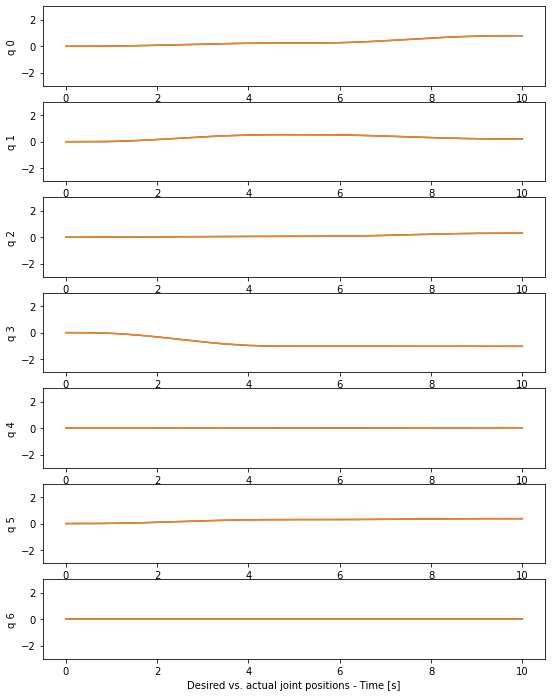

In [10]:
# plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

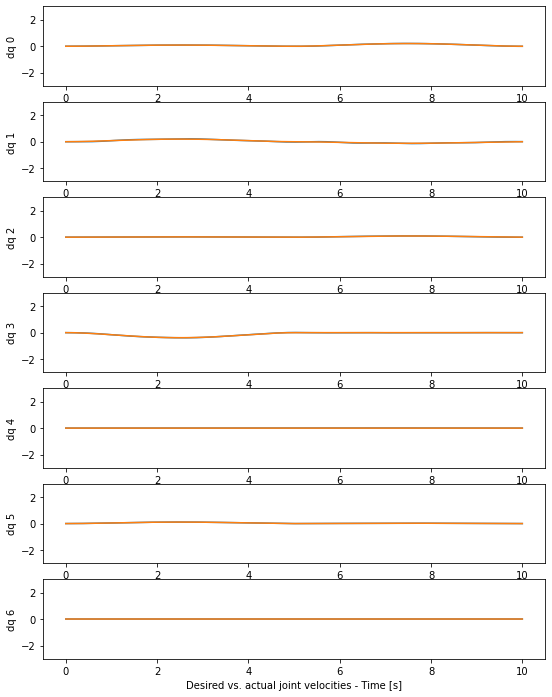

In [11]:
# plot the simulated vs. actual velocities of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

Text(0.5, 0, 'Positions of end-effector - Time [s]')

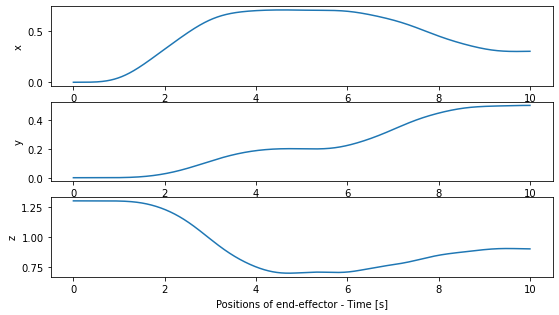

In [13]:
# plot the positions of end-effector

plt.figure(figsize=[9,12])
plt.subplot(7,1,1)
plt.plot(save_t, save_endeffector_positions[0,:])
plt.ylabel('x')
plt.xlabel('Positions of end-effector - Time [s]')

plt.subplot(7,1,2)
plt.plot(save_t, save_endeffector_positions[1,:])
plt.ylabel('y')
plt.xlabel('Positions of end-effector - Time [s]')

plt.subplot(7,1,3)
plt.plot(save_t, save_endeffector_positions[2,:])
plt.ylabel('z')
plt.xlabel('Positions of end-effector - Time [s]')

Text(0.5, 0, 'X')

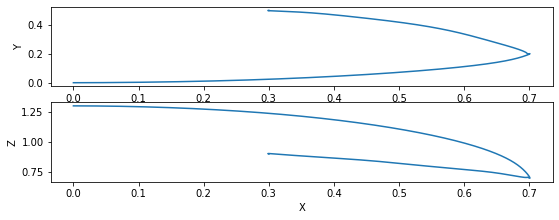

In [14]:
# plot the position of end-effector vs axes

plt.figure(figsize=[9,12])
plt.subplot(7,1,1)
plt.plot(save_endeffector_positions[0,:], save_endeffector_positions[1,:])
plt.ylabel('Y')
plt.xlabel('X')

plt.subplot(7,1,2)
plt.plot(save_endeffector_positions[0,:], save_endeffector_positions[2,:])
plt.ylabel('Z')
plt.xlabel('X')

Text(0.5, 0, 'Velocities of end-effector - Time [s]')

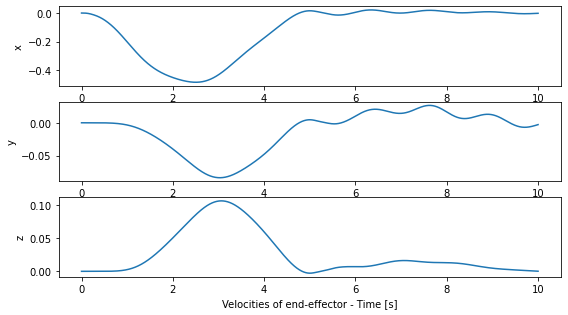

In [15]:
# plot the velocities of end-effector

plt.figure(figsize=[9,12])
plt.subplot(7,1,1)
plt.plot(save_t, save_endeffector_velocities[0,:])
plt.ylabel('x')
plt.xlabel('Velocities of end-effector - Time [s]')

plt.subplot(7,1,2)
plt.plot(save_t, save_endeffector_velocities[1,:])
plt.ylabel('y')
plt.xlabel('Velocities of end-effector - Time [s]')

plt.subplot(7,1,3)
plt.plot(save_t, save_endeffector_velocities[2,:])
plt.ylabel('z')
plt.xlabel('Velocities of end-effector - Time [s]')

## Question 3: End-effector control
As in Question 2, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

* Modify the ``robot_controller2`` function below to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions and directly mapping end-effector error to desired joint velocities (i.e. use P gains equal to 0 in joint space and do resolved-rate control).
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare results with Question 2
* Add a nullspace term to optimize a desired configuration of your choice and discuss the results

In [16]:
# Question 3: End-effector control
T = 10.
end_effector_init = np.array([[0], [0],[1.301]])
end_effector_goal1 = np.array([[0.7], [0.2],[0.7]])
end_effector_goal2 = np.array([[0.3], [0.5],[0.9]])

global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
global save_endeffector_positions, save_endeffector_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_endeffector_positions = np.zeros([3,int(np.ceil(T / 0.001))+1])
save_endeffector_velocities = np.zeros([3,int(np.ceil(T / 0.001))+1])
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0

desired_joint_positions = np.zeros([7,1])

# endeffector space controller
def robot_controller2(t, joint_positions, joint_velocities):
    
    global desired_joint_positions
    
    epsilon = 10e-4
    p = forward_kinematics(joint_positions)[0:3,3]
    p = p.reshape(3,1)
    Trans = np.vstack((np.hstack((np.identity(3),-p)),np.array([0,0,0,1])))
    J = np.dot(getAdjoint(Trans),get_space_jacobian(joint_positions))[3:6,:] 
    J_pinv = J.T.dot(np.linalg.inv(J.dot(J.T) + epsilon*np.eye(3)))

    P = np.array([15,15,15])
    
    if t < 5:
        desired_endeff_positions_function, desired_endeff_velocities_function = get_point_to_point_motion(5, end_effector_init, end_effector_goal1)
        desired_endeff_positions = desired_endeff_positions_function(t)
        desired_endeff_velocities = desired_endeff_velocities_function(t)
        
        desired_joint_velocities = J_pinv.dot(np.diag(P) @ (desired_endeff_positions - forward_kinematics(joint_positions)[0:3,3].reshape(3,1)) + desired_endeff_velocities)
        desired_joint_positions = desired_joint_positions + 0.001*desired_joint_velocities
        
    if t > 5:
        desired_endeff_positions_function, desired_endeff_velocities_function = get_point_to_point_motion(5, end_effector_goal1, end_effector_goal2)
        desired_endeff_positions = desired_endeff_positions_function(t-5)
        desired_endeff_velocities = desired_endeff_velocities_function(t-5)
    
        desired_joint_velocities = J_pinv.dot(np.diag(P) @ (desired_endeff_positions - forward_kinematics(joint_positions)[0:3,3].reshape(3,1)) + desired_endeff_velocities)
        desired_joint_positions = desired_joint_positions + 0.001*desired_joint_velocities
    

    # only use a D controller (i.e. on the desired joint velocities)
    D = np.array([4.,4,4,4,4,4,4.])
    
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    endeffector_positions = forward_kinematics(joint_positions.reshape(-1,1))[0:3,3].reshape(3,1)
    endeffector_velocities = get_space_jacobian(joint_positions.reshape(-1,1)).dot(joint_velocities)[3:6].reshape(3,1)

    
    ## this code is to save what the controller is doing for plotting and analysis after the simulation
    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_endeffector_positions, save_endeffector_velocities
    global save_des_joint_positions, save_des_joint_velocities, save_desired_endeff_positions, save_desired_endeff_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_endeffector_positions[:,ind] = endeffector_positions[:,0]
    save_endeffector_velocities[:,ind] = endeffector_velocities[:,0]
    save_t[ind] = t
    ind += 1
    ## end of saving code
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller2, T=T)

Text(0.5, 0, 'Desired vs. actual joint positions - Time [s]')

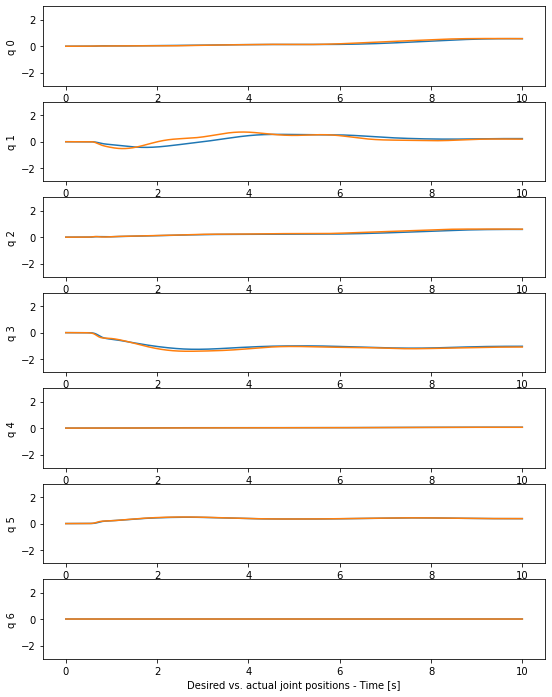

In [17]:
# plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_positions[i,:])
    plt.plot(save_t, save_des_joint_positions[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'q {i}')
plt.xlabel('Desired vs. actual joint positions - Time [s]')

Text(0.5, 0, 'Desired vs. actual joint velocities - Time [s]')

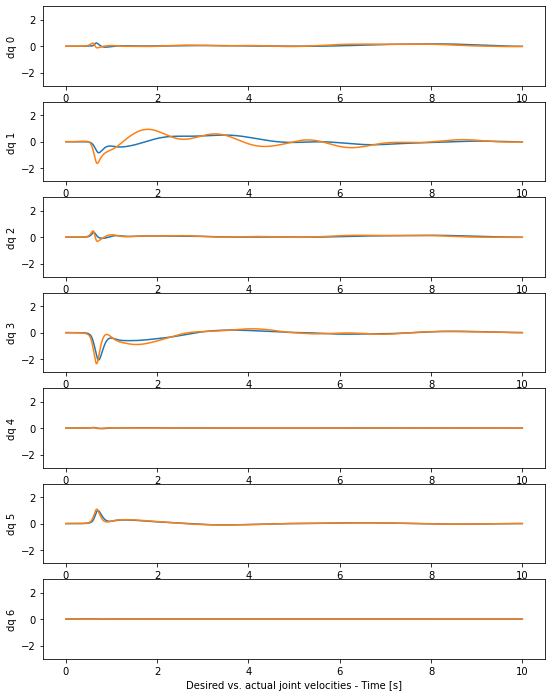

In [18]:
# plot the simulated vs. actual position of the robot
plt.figure(figsize=[9,12])
for i in range(7):
    plt.subplot(7,1,i+1)
    plt.plot(save_t, save_joint_velocities[i,:])
    plt.plot(save_t, save_des_joint_velocities[i,:])
    plt.ylim([-3,3])
    plt.ylabel(f'dq {i}')
plt.xlabel('Desired vs. actual joint velocities - Time [s]')

Text(0.5, 0, 'Positions of end-effector - Time [s]')

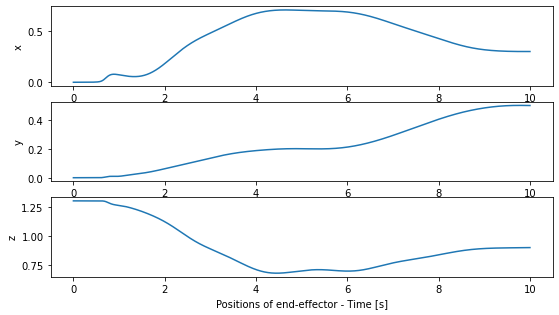

In [19]:
# plot the positions of end-effector

plt.figure(figsize=[9,12])
plt.subplot(7,1,1)
plt.plot(save_t, save_endeffector_positions[0,:])
plt.ylabel('x')
plt.xlabel('Positions of end-effector - Time [s]')

plt.subplot(7,1,2)
plt.plot(save_t, save_endeffector_positions[1,:])
plt.ylabel('y')
plt.xlabel('Positions of end-effector - Time [s]')

plt.subplot(7,1,3)
plt.plot(save_t, save_endeffector_positions[2,:])
plt.ylabel('z')
plt.xlabel('Positions of end-effector - Time [s]')

Text(0.5, 0, 'X')

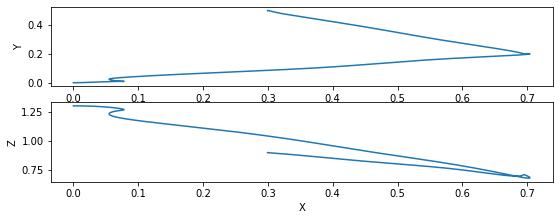

In [20]:
# plot the position of end-effector vs axes

plt.figure(figsize=[9,12])
plt.subplot(7,1,1)
plt.plot(save_endeffector_positions[0,:], save_endeffector_positions[1,:])
plt.ylabel('Y')
plt.xlabel('X')

plt.subplot(7,1,2)
plt.plot(save_endeffector_positions[0,:], save_endeffector_positions[2,:])
plt.ylabel('Z')
plt.xlabel('X')

Text(0.5, 0, 'Velocities of end-effector - Time [s]')

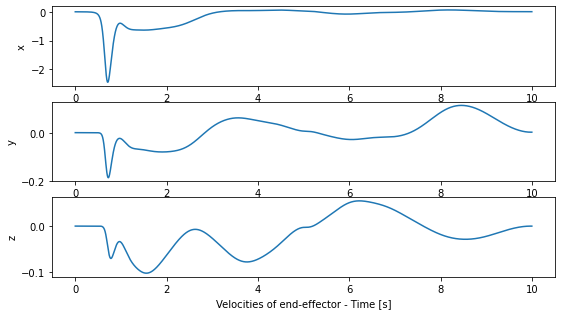

In [21]:
# plot the velocities of end-effector

plt.figure(figsize=[9,12])
plt.subplot(7,1,1)
plt.plot(save_t, save_endeffector_velocities[0,:])
plt.ylabel('x')
plt.xlabel('Velocities of end-effector - Time [s]')

plt.subplot(7,1,2)
plt.plot(save_t, save_endeffector_velocities[1,:])
plt.ylabel('y')
plt.xlabel('Velocities of end-effector - Time [s]')

plt.subplot(7,1,3)
plt.plot(save_t, save_endeffector_velocities[2,:])
plt.ylabel('z')
plt.xlabel('Velocities of end-effector - Time [s]')

In [22]:
# add an nullspace term
global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
global save_endeffector_positions, save_endeffector_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_des_joint_positions = np.zeros_like(save_joint_positions)
save_des_joint_velocities = np.zeros_like(save_joint_positions)
save_endeffector_positions = np.zeros([3,int(np.ceil(T / 0.001))+1])
save_endeffector_velocities = np.zeros([3,int(np.ceil(T / 0.001))+1])
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0

desired_joint_positions = np.zeros([7,1])

def robot_controller2_1(t, joint_positions, joint_velocities):
    
    global desired_joint_positions
    
    epsilon = 10e-4
    p = forward_kinematics(joint_positions)[0:3,3]
    p = p.reshape(3,1)
    Trans = np.vstack((np.hstack((np.identity(3),-p)),np.array([0,0,0,1])))
    J = np.dot(getAdjoint(Trans),get_space_jacobian(joint_positions))[3:6,:] 
    J_pinv = J.T.dot(np.linalg.inv(J.dot(J.T) + epsilon*np.eye(3)))

    configuration = np.array([[0],[0],[0.5],[-1],[0],[0.5],[0]])  # give a configuration
    
    P = np.array([20,20,20])
    
    if t < 5:
        desired_endeff_positions_function, desired_endeff_velocities_function = get_point_to_point_motion(5, end_effector_init, end_effector_goal1)
        desired_endeff_positions = desired_endeff_positions_function(t)
        desired_endeff_velocities = desired_endeff_velocities_function(t)
        
        desired_joint_velocities = J_pinv.dot(np.diag(P) @ (desired_endeff_positions - forward_kinematics(joint_positions)[0:3,3].reshape(3,1)) + desired_endeff_velocities) + (np.identity(7) - J_pinv.dot(J)).dot(configuration - joint_positions)  
        desired_joint_positions = desired_joint_positions + 0.001*desired_joint_velocities
        
    
    if t > 5:
        desired_endeff_positions_function, desired_endeff_velocities_function = get_point_to_point_motion(5, end_effector_goal1, end_effector_goal2)
        desired_endeff_positions = desired_endeff_positions_function(t-5)
        desired_endeff_velocities = desired_endeff_velocities_function(t-5)
    
        desired_joint_velocities = J_pinv.dot(np.diag(P) @ (desired_endeff_positions - forward_kinematics(joint_positions)[0:3,3].reshape(3,1)) + desired_endeff_velocities) + (np.identity(7) - J_pinv.dot(J)).dot(configuration - joint_positions)  
        desired_joint_positions = desired_joint_positions + 0.001*desired_joint_velocities
    
    
    D = np.array([4.,4,4,4,4,4,4.])
    
    desired_joint_torques = np.diag(D) @ (desired_joint_velocities - joint_velocities)
    
    endeffector_positions = forward_kinematics(joint_positions.reshape(-1,1))[0:3,3].reshape(3,1)
    endeffector_velocities = get_space_jacobian(joint_positions.reshape(-1,1)).dot(joint_velocities)[3:6].reshape(3,1)

    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_endeffector_positions, save_endeffector_velocities
    global save_des_joint_positions, save_des_joint_velocities, save_desired_endeff_positions, save_desired_endeff_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_des_joint_positions[:,ind] = desired_joint_positions[:,0]
    save_des_joint_velocities[:,ind] = desired_joint_velocities[:,0]
    save_endeffector_positions[:,ind] = endeffector_positions[:,0]
    save_endeffector_velocities[:,ind] = endeffector_velocities[:,0]
    save_t[ind] = t
    ind += 1
    
    return desired_joint_torques
        
robot_visualizer.display_ball(end_effector_goal1[:,0])
robot_visualizer.display_ball2(end_effector_goal2[:,0])
robot_visualizer.simulate_robot(robot_controller2_1, T=T)

## Question 4: Impedance control and gravity compensation
As in Question 2 and 3, we would like the robot to go from its initial configuration to the desired end-effector positions (in spatial coordinates) $[0.7, 0.2,0.7]$ in 5 seconds and then to the configuration $[0.3, 0.5,0.9]$ during the following 5 seconds.

In the previous questions, a gravity compensation controller was running "in the background" in addition to the control law you were computing. In this question, we remove this and implement a complete impedance controller with gravity compensation.

You are given a function ``robot_visualizer.rnea(q,dq,ddq)`` which implements the Recursive Newton Euler Algorithm (RNEA). It takes as arguments a vector of positions, velocities and accelerations, and computes (and returns) the following $M(q) \cdot \ddot{q} + C(q,\dot{q}) + G(q)$

* Modify the ``robot_controller3`` function below to implement an impedance controller with gravity compensation (add a small amount of joint damping, using a joint-space D gain of 0.1). Use this controller to move the robot from its initial configuration to the first goal (reaching at t=5) and the second goal (t=10) by interpolating the desired end effector positions as in the previous questions.
* Plot the resulting joint simulated and desired positions and velocities
* Plot the resulting end-effector positions and velocities
* Compare the controller when the small joint samping is on or off - can you explain the difference?
* Compare results with Question 2 and 3. Which controller would you rather choose and why?

In [23]:
# Question 4: Impedance control and gravity compensation
T = 10.

global save_joint_positions, save_joint_velocities, save_t, ind
global save_des_joint_positions, save_des_joint_velocities
global save_endeffector_positions, save_endeffector_velocities
save_joint_positions = np.zeros([7,int(np.ceil(T / 0.001))+1])
save_joint_velocities = np.zeros_like(save_joint_positions)
save_endeffector_positions = np.zeros([3,int(np.ceil(T / 0.001))+1])
save_endeffector_velocities = np.zeros([3,int(np.ceil(T / 0.001))+1])
save_t = np.zeros([int(np.ceil(T / 0.001))+1])
ind=0

# impedance controller
def robot_controller3(t, joint_positions, joint_velocities):
    
    p = forward_kinematics(joint_positions)[0:3,3]
    p = p.reshape(3,1)
    Trans = np.vstack((np.hstack((np.identity(3),-p)),np.array([0,0,0,1])))
    J = np.dot(getAdjoint(Trans),get_space_jacobian(joint_positions))[3:6,:] 
    
    if t < 5:
        desired_endeff_positions_function, desired_endeff_velocities_function = get_point_to_point_motion(5, end_effector_init, end_effector_goal1)
        desired_endeff_positions = desired_endeff_positions_function(t)
        desired_endeff_velocities = desired_endeff_velocities_function(t) 
    
    if t > 5:
        desired_endeff_positions_function, desired_endeff_velocities_function = get_point_to_point_motion(5, end_effector_goal1, end_effector_goal2)
        desired_endeff_positions = desired_endeff_positions_function(t-5)
        desired_endeff_velocities = desired_endeff_velocities_function(t-5)
    
    P = np.array([100, 100, 100])
    D = np.array([50, 50, 50])
    
    desired_joint_torques = (J.T).dot(np.diag(P) @ (desired_endeff_positions - p) + np.diag(D) @ (desired_endeff_velocities - J.dot(joint_velocities))) + robot_visualizer.rnea(joint_positions,np.zeros([7,1]),np.zeros([7,1]))   
    
    # only use the D controller to inject small joint damping
    D = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    
    desired_joint_torques = desired_joint_torques -np.diag(D) @ joint_velocities

    endeffector_positions = forward_kinematics(joint_positions.reshape(-1,1))[0:3,3].reshape(3,1)
    endeffector_velocities = get_space_jacobian(joint_positions.reshape(-1,1)).dot(joint_velocities)[3:6].reshape(3,1)

    global save_joint_positions, save_joint_velocities, save_t, ind
    global save_endeffector_positions, save_endeffector_velocities
    global save_des_joint_positions, save_des_joint_velocities, save_desired_endeff_positions, save_desired_endeff_velocities
    save_joint_positions[:,ind] = joint_positions[:,0]
    save_joint_velocities[:,ind] = joint_velocities[:,0]
    save_endeffector_positions[:,ind] = endeffector_positions[:,0]
    save_endeffector_velocities[:,ind] = endeffector_velocities[:,0]
    save_t[ind] = t
    ind += 1
    
    return desired_joint_torques
        
robot_visualizer.display_ball([0.7, 0.2,0.7])
robot_visualizer.display_ball2([0.3, 0.5,0.9])
robot_visualizer.simulate_robot(robot_controller3, T=T, gravity_comp = False)

Text(0.5, 0, 'Positions of end-effector - Time [s]')

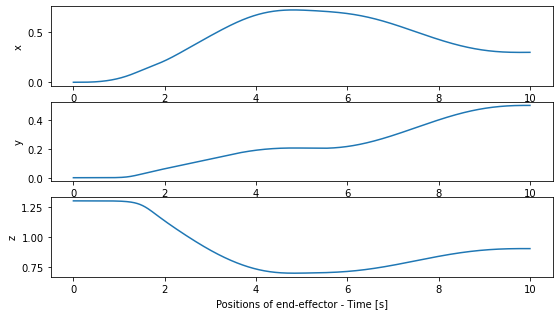

In [24]:
# plot the position of end-effector vs t

plt.figure(figsize=[9,12])
plt.subplot(7,1,1)
plt.plot(save_t, save_endeffector_positions[0,:])
plt.ylabel('x')
plt.xlabel('Positions of end-effector - Time [s]')

plt.subplot(7,1,2)
plt.plot(save_t, save_endeffector_positions[1,:])
plt.ylabel('y')
plt.xlabel('Positions of end-effector - Time [s]')

plt.subplot(7,1,3)
plt.plot(save_t, save_endeffector_positions[2,:])
plt.ylabel('z')
plt.xlabel('Positions of end-effector - Time [s]')

Text(0.5, 0, 'X')

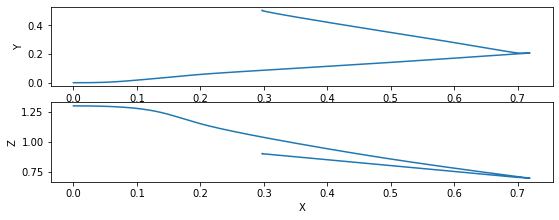

In [25]:
# plot the position of end-effector vs axes

plt.figure(figsize=[9,12])
plt.subplot(7,1,1)
plt.plot(save_endeffector_positions[0,:], save_endeffector_positions[1,:])
plt.ylabel('Y')
plt.xlabel('X')

plt.subplot(7,1,2)
plt.plot(save_endeffector_positions[0,:], save_endeffector_positions[2,:])
plt.ylabel('Z')
plt.xlabel('X')

Text(0.5, 0, 'Velocities of end-effector - Time [s]')

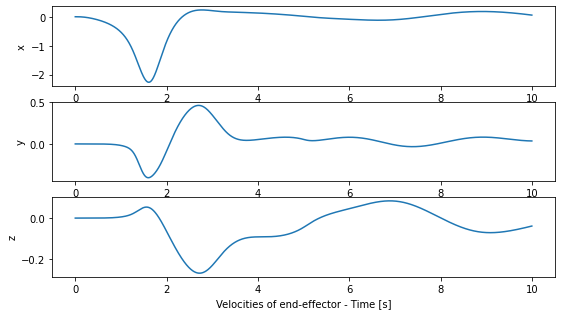

In [26]:
# plot the velocities of end-effector

plt.figure(figsize=[9,12])
plt.subplot(7,1,1)
plt.plot(save_t, save_endeffector_velocities[0,:])
plt.ylabel('x')
plt.xlabel('Velocities of end-effector - Time [s]')

plt.subplot(7,1,2)
plt.plot(save_t, save_endeffector_velocities[1,:])
plt.ylabel('y')
plt.xlabel('Velocities of end-effector - Time [s]')

plt.subplot(7,1,3)
plt.plot(save_t, save_endeffector_velocities[2,:])
plt.ylabel('z')
plt.xlabel('Velocities of end-effector - Time [s]')